In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, csc_matrix

%matplotlib inline

# Custom modules
import const
import func

In [2]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [3]:
const.TEST_FILES

['test_numeric', 'test_categorical_to_num', 'test_date']

In [4]:
# Load
train_date = func.load_data_file(const.TRAIN_FILES[2])
test_date = func.load_data_file(const.TEST_FILES[2])

Returning <open file '/Volumes/My Book/kaggle_bosch/train_date.pkl', mode 'rb' at 0x1162d4300>.pkl
Returning <open file '/Volumes/My Book/kaggle_bosch/test_date.pkl', mode 'rb' at 0x1162d4300>.pkl


In [5]:
y = func.read_last_column(os.path.join(const.BASE_PATH, const.TRAIN_FILES[0]+'.csv'))

In [6]:
y.head(3)

,Response
Id,
4,0
6,0
7,0


In [7]:
tmin_tr = train_date['data']['features'].data[train_date['data']['features'].indptr[:-1]]
tmin_tr[np.diff(train_date['data']['features'].indptr)==0]=np.nan
tmin_te = test_date['data']['features'].data[test_date['data']['features'].indptr[:-1]]
tmin_te[np.diff(test_date['data']['features'].indptr)==0]=np.nan

nmin_tr = train_date['data']['features'].indices[train_date['data']['features'].indptr[:-1]]
#nmin_tr[np.diff(train_date['data']['features'].indptr)==0]=np.nan
nmin_te = test_date['data']['features'].indices[test_date['data']['features'].indptr[:-1]]
#nmin_te[np.diff(test_date['data']['features'].indptr)==0]=np.nan

In [8]:
ids = pd.concat([train_date['data']['ids'], test_date['data']['ids']])
ids['start_time'] = np.concatenate([tmin_tr, tmin_te])
ids['start_time'] = ids['start_time'].astype(float).round(2)
ids['start_station'] = np.concatenate([nmin_tr, nmin_te])
#ids['start_station'] = ids['start_station'].astype(float).round(2)
ids = ids.merge(y.reset_index(), how='left')

In [9]:
ntrain = train_date['data']['ids'].shape[0]
train_test = ids.reset_index(drop=True).reset_index(drop=False)

In [10]:
# Train/test
train_test['f1'] = train_test['Id'].diff().fillna(0).astype(int)
train_test['f2'] = train_test['Id'].iloc[::-1].diff().fillna(0).astype(int)

In [11]:
train_test = train_test.sort_values(by=['start_station','start_time', 'Id'], ascending=True)
train_test['f3'] = train_test['Id'].diff().fillna(0).astype(int)
train_test['f4'] = train_test['Id'].iloc[::-1].diff().fillna(0).astype(int)

In [14]:
train_test.head()

,index,Id,start_time,start_station,Response,f1,f2,f3,f4
264308,264308,528757,0.73,0,1.0,1,-3,-1684594,-1
1132753,1132753,2265661,0.81,0,1.0,2,-2,5025,-1
1159681,1159681,2319366,0.93,0,1.0,3,-1,143019,-1
1154143,1154143,2308397,0.94,0,1.0,1,-4,717,-1
446240,446240,893315,1.21,0,1.0,1,-2,1892,-1


In [17]:
train_test['f4'][train_test.Response==1].value_counts()

-1          5264
-2514          3
-2802          3
-2642          3
-3024          2
-5469          2
-4530          2
-4599          2
-5132          2
-2859          2
-368           2
-3718          2
-3722          2
-4196          2
-4333          2
-5136          2
-3004          2
-2256          2
-7413          2
-3847          2
-1800          2
-3584          2
-4417          2
-2665          2
-2741          2
-63856         2
-4391          2
-3318          2
-2334          2
-1245          2
            ... 
-3285          1
-50398         1
-1258          1
-7872          1
-1274          1
-9474          1
-3185          1
-5232          1
-1130          1
-60521         1
-3081          1
-392203        1
-62300         1
-9238          1
-70680         1
-15387         1
-9250          1
-3109          1
 2313255       1
-70716         1
-586816        1
-3137          1
-1090          1
-1094          1
-54344         1
-11337         1
-58442         1
-5200         

In [15]:
train_test.to_csv(os.path.join(const.DATA_PATH, 'feat_set_leaks.csv'), index=False)

In [12]:
print train_test[(train_test.Response==1) & (train_test.f4==-1)].Id.count()
print train_test[(train_test.Response==0) & (train_test.f4==-1)].Id.count()

5264
65795


In [13]:
train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
train = train_test.iloc[:ntrain, :]

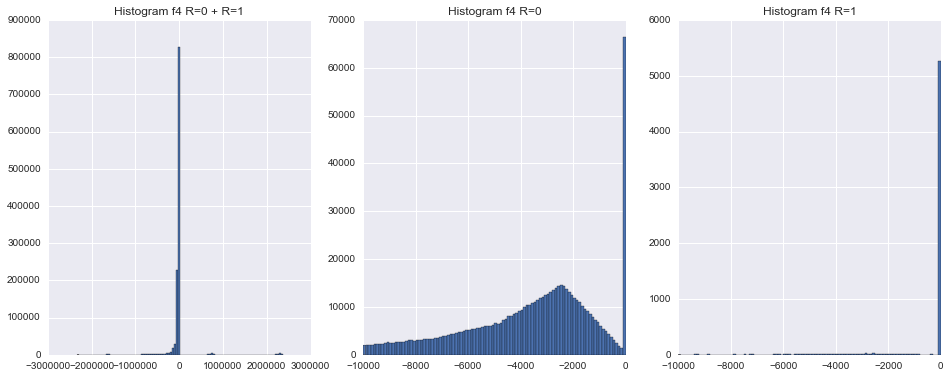

In [14]:
r=[-15, 1]
#r=[0,15]
#r=[0,1e4]
r=[-1e4,0]
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
train_test[train_test.Response>=0].f4.hist(bins=100, ax=ax1)
train_test[train_test.Response==0].f4.hist(bins=100, ax=ax2, range=r)
train_test[train_test.Response==1].f4.hist(bins=100, ax=ax3, range=r)

ax1.set_title('Histogram f4 R=0 + R=1')
ax2.set_title('Histogram f4 R=0')
ax3.set_title('Histogram f4 R=1')

In [15]:
train_test[['f1','f2','f3','f4']].corr()

,f1,f2,f3,f4
f1,1.000000e+00,1.293836e-09,0.004663,0.000007
f2,1.293836e-09,1.000000e+00,0.000008,0.004746
f3,4.663351e-03,7.999361e-06,1.000000,0.076520
f4,7.136053e-06,4.746437e-03,0.076520,1.000000


In [16]:
list(train.columns)

['Id', 'start_time', 'start_station', 'Response', 'f1', 'f2', 'f3', 'f4']

In [28]:
features = np.setdiff1d(list(train.columns), ['Response', 'Id','start_station'])

In [29]:
features

array(['f1', 'f2', 'f3', 'f4', 'start_time'], 
      dtype='|S13')

In [30]:
y = train.Response.ravel()
X_train = np.array(train[features])

print('train: {0}'.format(train.shape))
prior = np.sum(y) / (1.*len(y))

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 2,
    'eval_metric': 'auc',
    'base_score': prior
}


dtrain = xgb.DMatrix(X_train, label=y)
res = xgb.cv(xgb_params, dtrain, num_boost_round=10, nfold=4, seed=0, stratified=True,
             early_stopping_rounds=1, verbose_eval=1, show_stdv=True)

cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))

train: (1183747, 8)
[0]	train-auc:0.829911+0.104271	test-auc:0.826462+0.107041
[1]	train-auc:0.891711+0.00150777	test-auc:0.888985+0.00263146
[2]	train-auc:0.892755+0.00138299	test-auc:0.889887+0.0028623
[3]	train-auc:0.893497+0.00187417	test-auc:0.889969+0.00257306
[4]	train-auc:0.894714+0.00214455	test-auc:0.890845+0.00199651
CV-Mean: 0.89084525+0.00199651388362


In [20]:
# Without start station: 0.89008475
# With start station: 0.890845
# Without f1: 0.88678875
# Without f2: 0.88699775
# Without f3: 0.88875625
# Without f4: 0.65140425

In [65]:
def callback_test(x):
    print x[0].get_score()
    
    with open(os.path.join(const.DATA_PATH,'callback_fi_{}.log'.format(x[2])), 'w') as f:
        f.write(str(x[0].get_score()))
    with open(os.path.join(const.DATA_PATH,'callback__eval_{}.log'.format(x[2])), 'w') as f:
        f.write(str(x[6]))
    
    print 
    print('Joost')

In [66]:
y = train.Response.ravel()
X_train = np.array(train[features])

print('train: {0}'.format(train.shape))
prior = np.sum(y) / (1.*len(y))

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 2,
    'eval_metric': 'auc',
    'base_score': prior,
    'num_round': 10,
    'seed': 123,
    'early_stopping': 20
}


dtrain = xgb.DMatrix(X_train, label=y)

watchlist = [(dtrain,'train')]

eval_result = {}

bst = xgb.train(xgb_params, 
            dtrain, 
            num_boost_round=xgb_params['num_round'], 
            evals=watchlist,
            evals_result=eval_result,
            early_stopping_rounds=xgb_params['early_stopping'],
            verbose_eval=1,
            callbacks=[callback_test])

train: (1183747, 8)
{'f1': 1, 'f2': 7, 'f3': 5}

Joost
[0]	train-auc:0.863865
Will train until train-auc hasn't improved in 20 rounds.
{'f1': 1, 'f2': 7, 'f3': 8, 'f4': 11}

Joost
[1]	train-auc:0.892687
{'f1': 1, 'f2': 11, 'f3': 10, 'f4': 19}

Joost
[2]	train-auc:0.894366
{'f1': 1, 'f2': 16, 'f3': 10, 'f4': 29}

Joost
[3]	train-auc:0.895025
{'f1': 1, 'f2': 16, 'f3': 14, 'f4': 39}

Joost
[4]	train-auc:0.896359
{'f0': 4, 'f1': 4, 'f2': 16, 'f3': 19, 'f4': 39}

Joost
[5]	train-auc:0.896628
{'f0': 5, 'f1': 4, 'f2': 16, 'f3': 22, 'f4': 50}

Joost
[6]	train-auc:0.897318
{'f0': 5, 'f1': 4, 'f2': 19, 'f3': 22, 'f4': 61}

Joost
[7]	train-auc:0.897101
{'f0': 5, 'f1': 4, 'f2': 19, 'f3': 22, 'f4': 75}

Joost
[8]	train-auc:0.897247
{'f0': 8, 'f1': 9, 'f2': 19, 'f3': 29, 'f4': 75}

Joost
[9]	train-auc:0.897679


In [32]:
eval_result

{'train': {'auc': [0.863865,
   0.892687,
   0.894366,
   0.895025,
   0.896359,
   0.896628,
   0.897318,
   0.897101,
   0.897247,
   0.897679]}}